# Libraries and functions

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
#from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [15]:

def fit_and_plot_powerlaw(x, y, ax=None, plot_kwargs=None, fit_kwargs=None):
    x = np.asarray(x)
    y = np.asarray(y)
    n = x.size

    # 1) do the linear fit in log–log
    logx = np.log(x)
    logy = np.log(y)
    # gamma is slope, log(k) is intercept
    gamma, logk = np.polyfit(logx, logy, 1)
    k = np.exp(logk)

    # 2) compute standard error on gamma
    #   residual variance σ² = SSR / (n−2)
    y_fit = gamma*logx + logk
    resid = logy - y_fit
    ssr = np.sum(resid**2)
    sigma2 = ssr / (n - 2)
    #   Sxx = Σ (logx − mean(logx))²
    Sxx = np.sum((logx - logx.mean())**2)
    stderr_gamma = np.sqrt(sigma2 / Sxx)

    # 3) plotting
    if ax is None:
        ax = plt.gca()
    if plot_kwargs is None:
        plot_kwargs = {}
    if fit_kwargs is None:
        fit_kwargs = {"linestyle":"--", "linewidth":2}

    # raw data
    ax.plot(x, y, label="data", **plot_kwargs)
    # fitted power-law
    ax.plot(x, k * x**gamma, label=f"fit: $\gamma_2$={gamma:.3f}±{stderr_gamma:.3f}", **fit_kwargs)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("P", fontsize=14)
    ax.set_ylabel(r"$\lambda^*$", fontsize=14)
    ax.legend()
    plt.show()

    return k, gamma, stderr_gamma



In [16]:
def fit_phi(log_x_grid, mean_val_err_arr, P_arr_fit, min_P, x_left, x_right, colorlist, ax=None):
    """
    Fit y ≈ k * x^(-gamma) on each of the mean‐error curves in double‐log space,
    compute per‐curve slope uncertainties, then average the exponents and prefactors.

    Parameters
    ----------
    log_x_grid : array_like, shape (n_x,)
        The x‐axis values for all curves.
    mean_val_err_arr : array_like, shape (n_P, n_x)
        The mean test‐error curves for each P in P_arr_fit.
    P_arr_fit : array_like, shape (n_P,)
        The list of P values corresponding to the rows of mean_val_err_arr.
    x_left : float or None
        Left cutoff on the *normalized* x‐axis; if None, no left cutoff.
    x_right : float or None
        Right cutoff on the *normalized* x‐axis; if None, no right cutoff.

    Returns
    -------
    gamma_1 : float
        Mean fitted exponent γ across all curves.
    k1      : float
        Mean fitted prefactor k across all curves.
    err_gamma_1 : float
        Standard error on the mean exponent (from the per‐curve fit uncertainties).
    """
    gammas = []
    ks      = []
    sigmas  = []

    for i_P, P in enumerate(P_arr_fit):
        y = mean_val_err_arr[i_P+min_P]
        x = log_x_grid

        # find reference point (where train error ~ 0.25)
        idx   = np.nanargmin(y)
        x_ref = x[idx]
        y_ref = y[idx]

        # normalize both axes
        x_norm = x / x_ref
        y_norm = y / y_ref

        # select the fitting window
        mask = np.isfinite(y_norm)
        if x_left is not None:
            mask &= (x_norm >= x_left)
        if x_right is not None:
            mask &= (x_norm <= x_right)
        # also require positive for log
        mask &= (x_norm > 0) & (y_norm > 0)

        xs = x_norm[mask]
        ys = y_norm[mask]
        log_xs = np.log10(xs)
        log_ys = np.log10(ys)

        # linear regression in log-log; returns coeffs [slope, intercept]
        p, cov = np.polyfit(log_xs, log_ys, 1, cov=True)
        slope, intercept = p
        sigma_slope = np.sqrt(cov[0,0])

        # translate to power‐law params
        gamma_i = -slope
        k_i     = 10**intercept

        gammas.append(gamma_i)
        ks.append(k_i)
        sigmas.append(sigma_slope)

        # overlay the fit as a dashed line on your existing plot
        y_fit = k_i * xs**(-gamma_i)
        if ax==None:
            plt.plot(xs, y_fit, "--", color=colorlist[i_P+min_P])
        else:
            ax.plot(xs, y_fit, "--", color=colorlist[i_P+min_P])

    gammas = np.array(gammas)
    ks      = np.array(ks)
    sigmas  = np.array(sigmas)

    # mean exponent and prefactor
    gamma_1 = gammas.mean()
    k1      = ks.mean()
    # standard error on the mean exponent
    err_gamma_1 = np.sqrt((sigmas**2/len(sigmas)).sum())

    return gamma_1, k1, err_gamma_1


def fit_phi_display(log_x_grid, mean_val_err_arr, P_arr_fit, min_P, x_left, x_right, colorlist, ax=None):
    """
    Fit y ≈ k * x^(-gamma) on each of the mean‐error curves in double‐log space,
    compute per‐curve slope uncertainties, then average the exponents and prefactors.

    Parameters
    ----------
    log_x_grid : array_like, shape (n_x,)
        The x‐axis values for all curves.
    mean_val_err_arr : array_like, shape (n_P, n_x)
        The mean test‐error curves for each P in P_arr_fit.
    P_arr_fit : array_like, shape (n_P,)
        The list of P values corresponding to the rows of mean_val_err_arr.
    x_left : float or None
        Left cutoff on the *normalized* x‐axis; if None, no left cutoff.
    x_right : float or None
        Right cutoff on the *normalized* x‐axis; if None, no right cutoff.

    Returns
    -------
    gamma_1 : float
        Mean fitted exponent γ across all curves.
    k1      : float
        Mean fitted prefactor k across all curves.
    err_gamma_1 : float
        Standard error on the mean exponent (from the per‐curve fit uncertainties).
    """
    gammas = []
    ks      = []
    sigmas  = []

    for i_P, P in enumerate(P_arr_fit):
        y = mean_val_err_arr[i_P+min_P]
        x = log_x_grid

        # find reference point (where train error ~ 0.25)
        idx   = np.nanargmin(y)
        x_ref = x[idx]
        y_ref = y[idx]

        # normalize both axes
        x_norm = x / x_ref
        y_norm = y / y_ref

        # select the fitting window
        mask = np.isfinite(y_norm)
        if x_left is not None:
            mask &= (x_norm >= x_left)
        if x_right is not None:
            mask &= (x_norm <= x_right)
        # also require positive for log
        mask &= (x_norm > 0) & (y_norm > 0)

        xs = x_norm[mask]
        ys = y_norm[mask]
        log_xs = np.log10(xs)
        log_ys = np.log10(ys)

        # linear regression in log-log; returns coeffs [slope, intercept]
        p, cov = np.polyfit(log_xs, log_ys, 1, cov=True)
        slope, intercept = p
        sigma_slope = np.sqrt(cov[0,0])

        # translate to power‐law params
        gamma_i = -slope
        k_i     = 10**intercept

        gammas.append(gamma_i)
        ks.append(k_i)
        sigmas.append(sigma_slope)

        # overlay the fit as a dashed line on your existing plot
        y_fit = k_i * (log_x_grid/x_ref)**(-gamma_i)
        if ax==None:
            plt.plot(log_x_grid/x_ref, y_fit, "--", color=colorlist[i_P+min_P])
        else:
            ax.plot(log_x_grid/x_ref, y_fit, "--", color=colorlist[i_P+min_P])

    gammas = np.array(gammas)
    ks      = np.array(ks)
    sigmas  = np.array(sigmas)

    # mean exponent and prefactor
    gamma_1 = gammas.mean()
    k1      = ks.mean()
    # standard error on the mean exponent
    err_gamma_1 = np.sqrt((sigmas**2/len(sigmas)).sum())

    return gamma_1, k1, err_gamma_1

In [33]:
def plot_results(dataset, P_arr, seed_arr, log_x_grid, exponential=None, ylimit=(0.05,1.0)):
        
    colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])    
    # Store interpolated results here
    to_save = {}
    to_save["P_arr"] = P_arr
    to_save["seed_arr"] = seed_arr
    to_save["log_x_grid"] = log_x_grid
    
    plt.figure(figsize=(6,4))
    
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        
        for seed in seed_arr:
            name_file = f"../../savings/{model}_{dataset}_P{P}_seed{seed}_{WD_name}{WD}{final}.npy"
            logs_saved = np.load(name_file, allow_pickle=True).item()
            if exponential == False:
                model_norm = np.array(logs_saved["model_norm"])
            else:
                model_norm = np.exp(np.array(logs_saved["model_norm"]))
            val_error = np.array(logs_saved["val_error"])*0.01
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_val_error_arr[i_P] = mean_val_error
    
        # Plot the mean curve
        plt.plot(log_x_grid, mean_val_error, label=f"P={P}", color=colorlist[i_P])
        
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(r"$\lambda(t)$", fontsize=14)
    plt.ylabel("Test Error", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05,1.0))
    plt.title(dataset)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.ylim(ylimit)
    plt.show()

    ################

    # Store interpolated results here
    mean_curves = {}
    
    plt.figure(figsize=(6,4))
    l_0_arr = np.zeros(len(P_arr))
    
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            name_file = f"../../savings/{model}_{dataset}_P{P}_seed{seed}_{WD_name}{WD}{final}.npy"
            logs_saved = np.load(name_file, allow_pickle=True).item()
            if exponential == False:
                model_norm = np.array(logs_saved["model_norm"])
            else:
                model_norm = np.exp(np.array(logs_saved["model_norm"]))
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
            idx_zero  = np.argmin((val_error)**2)
            where_zero = model_norm[idx_zero]
            w_z += where_zero/(len(seed_arr))
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        l_0_arr[i_P] = w_z
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_curves[i_P] = mean_val_error
    to_save["mean_val_error_arr"] = mean_val_error_arr
    to_save["l_0_arr"] = l_0_arr
    return l_0_arr, to_save

In [34]:

def fit_gamma_1(min_P, exponential=False, x_left = None, x_right = None, ylimits = (0.98, 10)):
    P_arr_fit = P_arr[min_P:]
    colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])  
    
    plt.figure(figsize=(6,4))
    wd=0.0
    
    for i_P, P in enumerate(P_arr_fit):
        interpolated_val_errors = []
        
        for seed in seed_arr:
            name_file = f"../../savings/{model}_{dataset}_P{P}_seed{seed}_{WD_name}{WD}{final}.npy"
            logs_saved = np.load(name_file, allow_pickle=True).item()
            if exponential==False:
                model_norm = np.array(logs_saved["model_norm"])
            else:
                model_norm = np.exp(np.array(logs_saved["model_norm"]))
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    
        idx = np.nanargmin(mean_val_error)
        # Plot the mean curve
        plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
                 color=colorlist[i_P+min_P], label=f"P={P}")

    gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right, colorlist)
    to_save["k1"] = k1
    to_save["gamma_1"] = gamma_1
    to_save["err_gamma_1"] = err_gamma_1
    
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(r"$\lambda(t)/\lambda_{opt}$", fontsize=14)
    plt.ylabel(r"\epsilon/\epsilon_{opt}", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05,1.0))
    plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.ylim(ylimits)
    plt.show()
    return P_arr_fit, gamma_1, k1, err_gamma_1

In [35]:
def final_plot(P_arr, gamma_1, gamma_2, constant, ylimits = (1e-2,1.05)):
    print("gamma_pred = ", gamma_1*gamma_2)
    eps_lam_star_P_arr = np.zeros(len(P_arr))

    lambda_star_arr = np.zeros(len(P_arr))

    for i_P,P in enumerate(P_arr):
         idx = np.nanargmin(mean_val_error_arr[i_P])
         #idx = ((log_x_grid-l_power_law[i_P])**2) 
         eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
         lambda_star_arr[i_P] = log_x_grid[idx]

    to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
    to_save["lambda_star_arr"] = lambda_star_arr
    
    plt.plot(P_arr, eps_lam_star_P_arr, label="measured")
    
    plt.plot(P_arr, constant*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue", label="predicted")
    #plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"P", fontsize=14)
    plt.ylabel("Test Error", fontsize=14)
    plt.legend()
    plt.title(dataset)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    plt.ylim(ylimits)
    plt.show()

# Main analysis

## CNN

### MNIST

/tmp/ipykernel_19846/2013085822.py:31: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


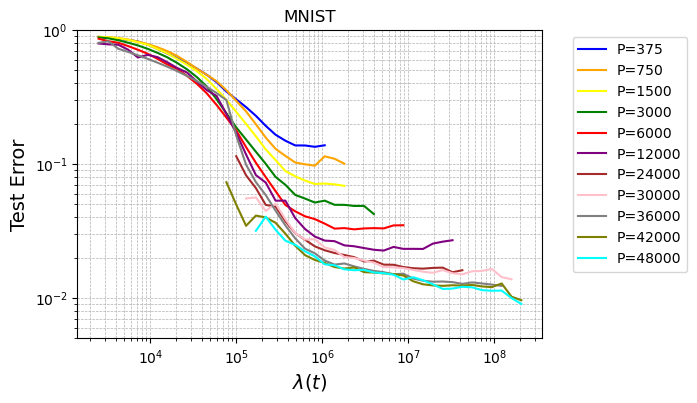

/tmp/ipykernel_19846/2013085822.py:81: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
/tmp/ipykernel_19846/3942581446.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


<Figure size 600x400 with 0 Axes>

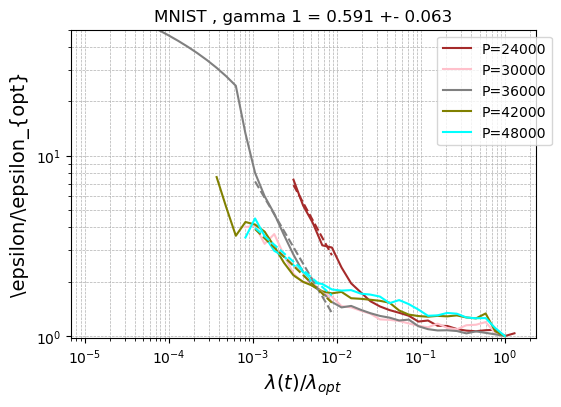

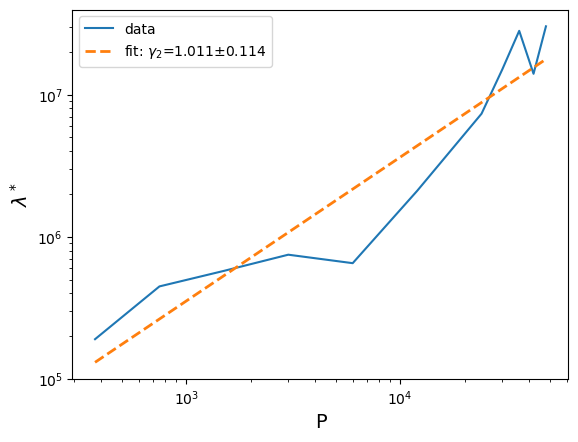

Fitted power law: k2 = 327.3, gamma2 = 1.011
gamma_pred =  0.5973236848131338


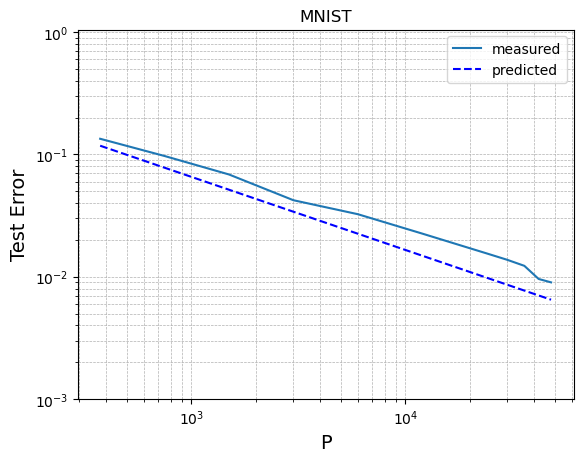

In [26]:
model = "CNN"
dataset = "MNIST"
final = "_INIT0.05"
WD = 0.0
P_arr = np.array([375, 750, 1500, 3000, 6000, 12000, 24000, 30000, 36000, 42000, 48000]) 
seed_arr = np.arange(100, 131, 1)
log_x_grid = np.logspace(3.4, 9, num=50)
ylim = (0.005,1.0)

mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))
    
l_0_arr, to_save = plot_results(dataset, P_arr, seed_arr, log_x_grid, exponential=False, ylimit=ylim)

min_P = 6
x_left = 1e-3
x_right = 1e-2
ylimits = (0.98, 50)

exponential = False
to_save["min_P"] = min_P

P_arr_fit, gamma_1, k1, err_gamma_1 = fit_gamma_1(min_P, exponential, x_left, x_right, ylimits = ylimits)

l_power_law = l_0_arr[:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr[:], l_power_law)
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

constant = 900
final_plot(P_arr, gamma_1, gamma_2, constant, ylimits = (1e-3,1.05))

### CIFAR10

/tmp/ipykernel_19846/2013085822.py:31: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


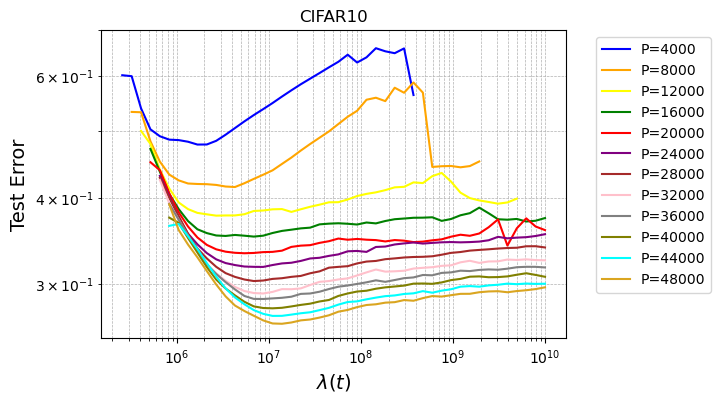

/tmp/ipykernel_19846/2013085822.py:81: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
/tmp/ipykernel_19846/3942581446.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


<Figure size 600x400 with 0 Axes>

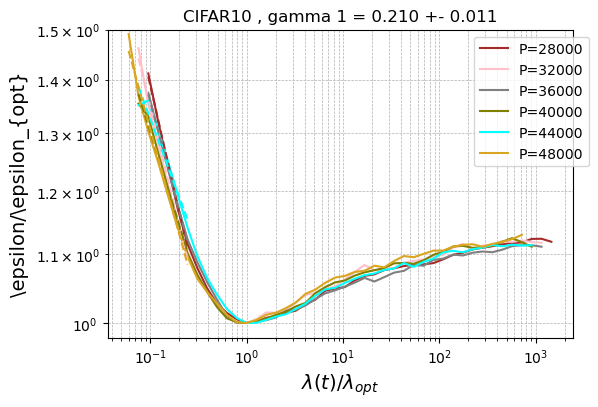

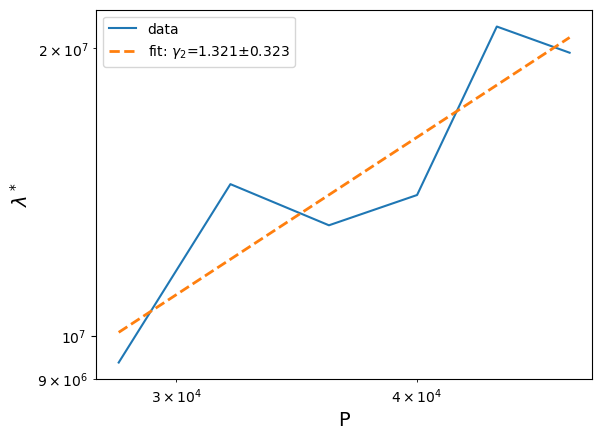

Fitted power law: k2 = 13.48, gamma2 = 1.321
gamma_pred =  0.2769494430564887


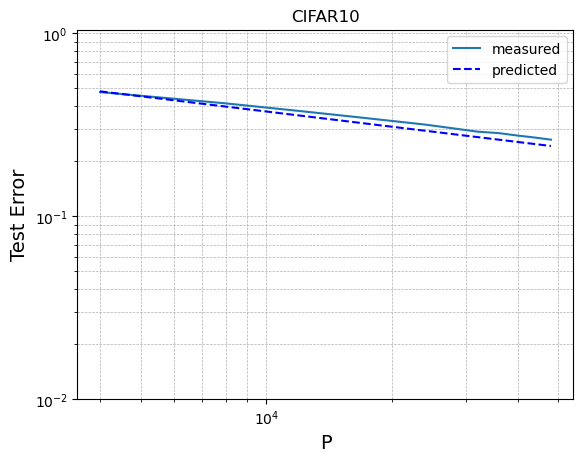

In [20]:
model = "CNN"
dataset = "CIFAR10"
final = ""
WD = 0.0
P_arr = np.arange(4000, 48001, 4000)
seed_arr = np.arange(120,150)
log_x_grid = np.logspace(5, 10, num=50)
ylim = (0.25,0.7)

mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))
    
l_0_arr, to_save = plot_results(dataset, P_arr, seed_arr, log_x_grid, exponential=False, ylimit=ylim)

min_P = 6
x_left = None
x_right = 3e-1
ylimits = (0.98, 1.5)

exponential = False
to_save["min_P"] = min_P

P_arr_fit, gamma_1, k1, err_gamma_1 = fit_gamma_1(min_P, exponential, x_left, x_right, ylimits = ylimits)

l_power_law = l_0_arr[min_P:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr[min_P:], l_power_law)
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

constant = 10
final_plot(P_arr, gamma_1, gamma_2, constant, ylimits = (1e-2,1.05))

### CIFAR100

/tmp/ipykernel_19846/2013085822.py:31: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


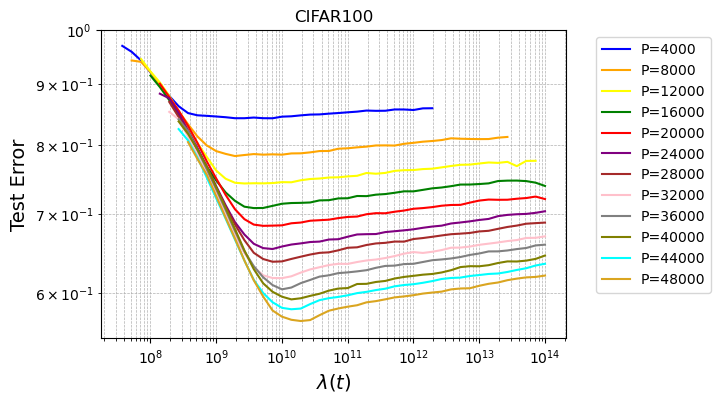

/tmp/ipykernel_19846/2013085822.py:81: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
/tmp/ipykernel_19846/3942581446.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


<Figure size 600x400 with 0 Axes>

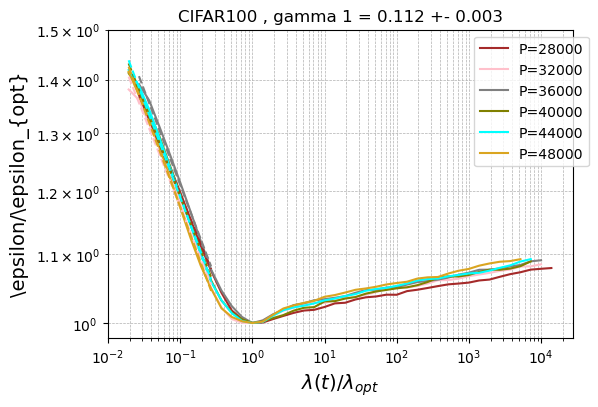

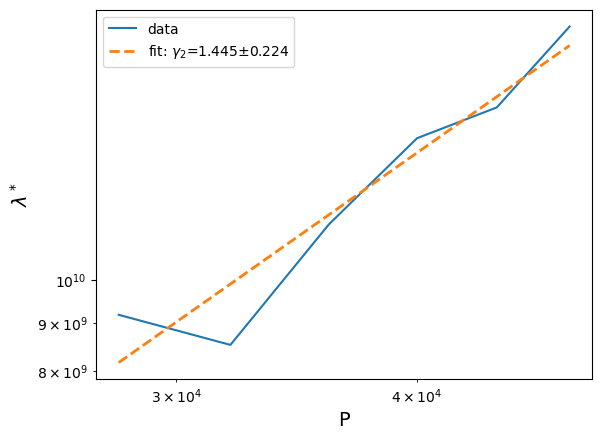

Fitted power law: k2 = 3066, gamma2 = 1.445
gamma_pred =  0.1620343218803962


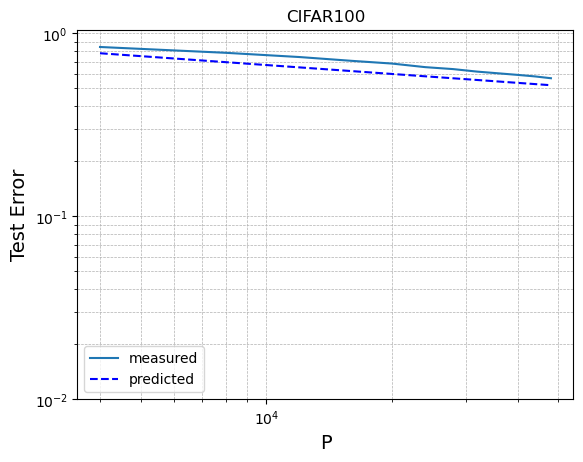

In [22]:
model = "CNN"
dataset = "CIFAR100"
final = ""
WD = 0.0
P_arr = np.arange(4000, 48001, 4000)
seed_arr = np.arange(120,138)
log_x_grid = np.logspace(7, 14, num=50)
ylim = (0.55,1.)

mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))
    
l_0_arr, to_save = plot_results(dataset, P_arr, seed_arr, log_x_grid, exponential=False, ylimit=ylim)

min_P = 6
x_left = None
x_right = 3e-1
ylimits = (0.98, 1.5)

exponential = False
to_save["min_P"] = min_P

P_arr_fit, gamma_1, k1, err_gamma_1 = fit_gamma_1(min_P, exponential, x_left, x_right, ylimits = ylimits)

l_power_law = l_0_arr[min_P:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr[min_P:], l_power_law)
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

constant = 8
final_plot(P_arr, gamma_1, gamma_2, constant, ylimits = (1e-2,1.05))

## ResNet

### MNIST

/tmp/ipykernel_19846/315783976.py:31: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


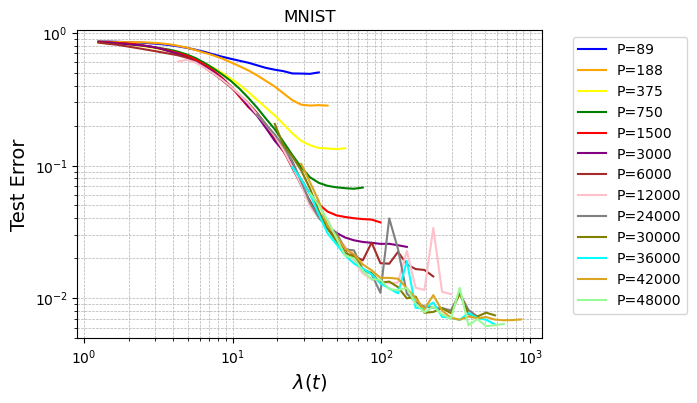

/tmp/ipykernel_19846/315783976.py:81: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
/tmp/ipykernel_19846/3312469580.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


<Figure size 600x400 with 0 Axes>

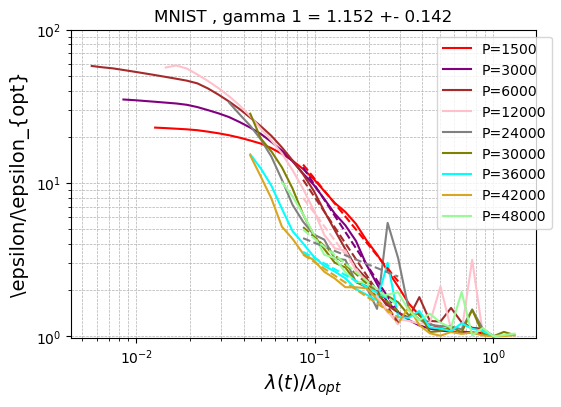

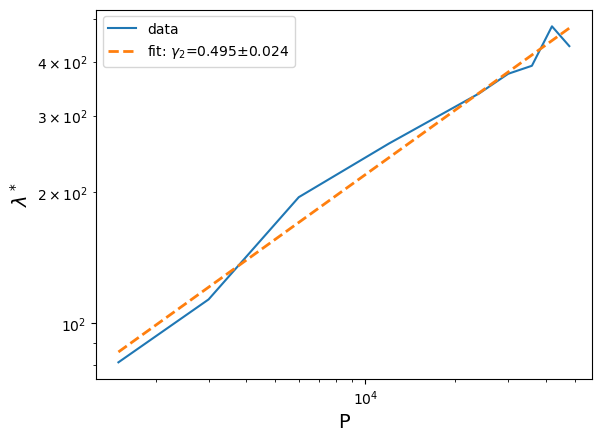

Fitted power law: k2 = 2.299, gamma2 = 0.4951
gamma_pred =  0.5702308635055894


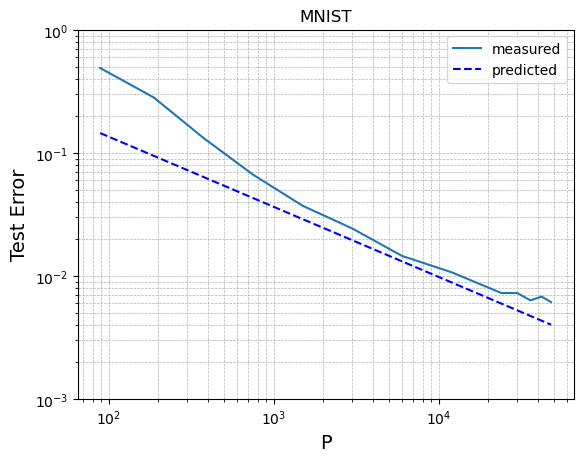

In [37]:
model = "savings_MNIST/ResNet"
dataset = "MNIST"
final = ""
WD_name = "wd"
WD = 0.0
P_arr = np.array([89, 188, 375, 750, 1500, 3000, 6000, 12000, 24000, 30000, 36000, 42000, 48000])
seed_arr = np.arange(1140,1169,1)
log_x_grid = np.logspace(0.1, 3, num=50)

mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))
    
l_0_arr, to_save = plot_results(dataset, P_arr, seed_arr, log_x_grid, exponential=False, ylimit=(5e-3,1.05))

min_P = 4
x_left = 8e-2
x_right = 3e-1
exponential = False
to_save["min_P"] = min_P

P_arr_fit, gamma_1, k1, err_gamma_1 = fit_gamma_1(min_P, exponential, x_left, x_right, ylimits = (0.98, 100))

l_power_law = l_0_arr[min_P:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr[min_P:], l_power_law)
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

constant = 10
final_plot(P_arr, gamma_1, gamma_2, constant, ylimits = (1e-3,1.01))

### CIFAR10

/tmp/ipykernel_19846/315783976.py:31: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


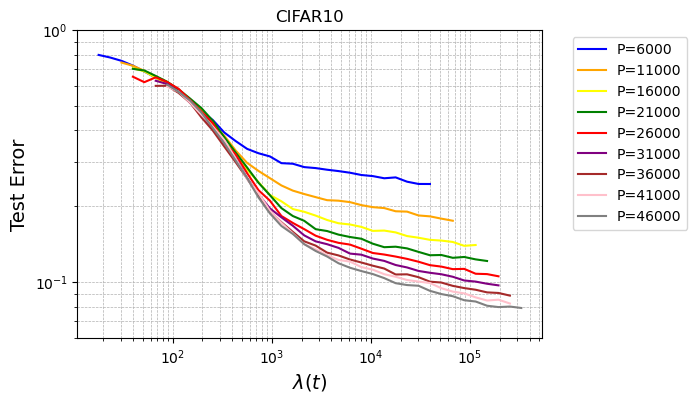

/tmp/ipykernel_19846/315783976.py:81: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
/tmp/ipykernel_19846/3312469580.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


<Figure size 600x400 with 0 Axes>

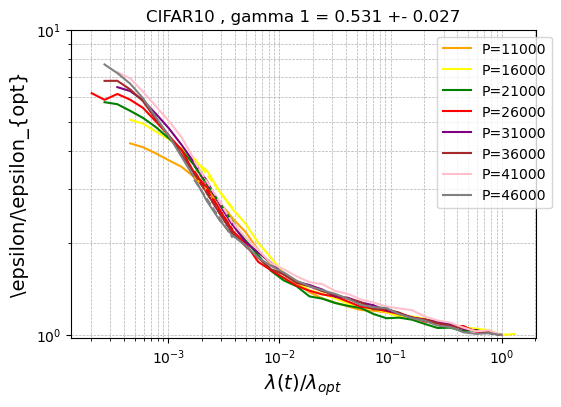

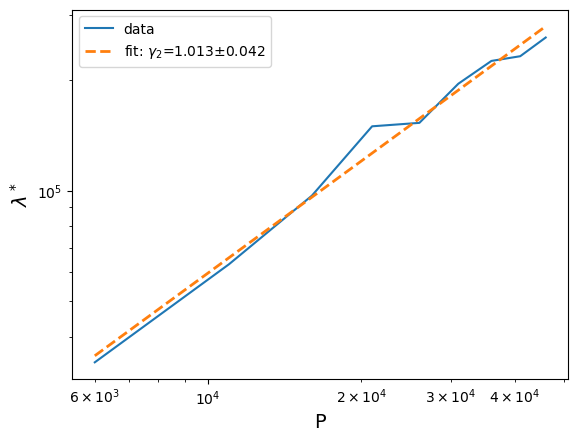

Fitted power law: k2 = 5.288, gamma2 = 1.013
gamma_pred =  0.5383306485082903


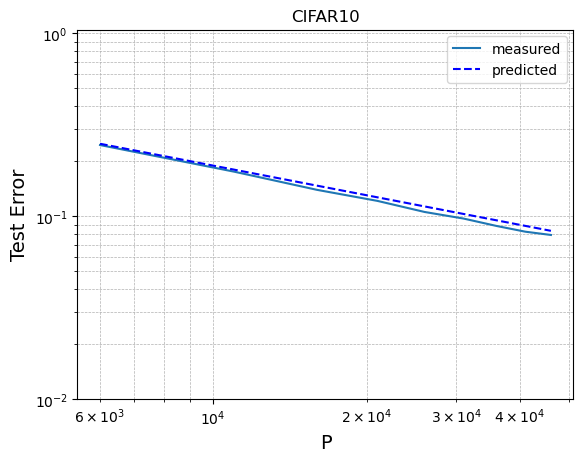

In [42]:
model = "ResNet"
dataset = "CIFAR10"
WD_name = "WD"
final = "_INIT0.05"
WD = 0.0
P_arr = np.arange(6000, 46001, 5000)
seed_arr = np.arange(800,812)
log_x_grid = np.logspace(0.1, 5.75, num=50)

mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))
    
l_0_arr, to_save = plot_results(dataset, P_arr, seed_arr, log_x_grid, exponential=False, ylimit=(0.06,1.0))

min_P = 1
x_left = 1.5e-3
x_right = 4e-3
exponential = False
to_save["min_P"] = min_P

P_arr_fit, gamma_1, k1, err_gamma_1 = fit_gamma_1(min_P, exponential, x_left, x_right, ylimits = (0.98, 10))

l_power_law = l_0_arr[:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr, l_power_law)
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

constant = 500
final_plot(P_arr, gamma_1, gamma_2, constant, ylimits = (1e-2,1.05))

### CIFAR100

/tmp/ipykernel_19846/315783976.py:31: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


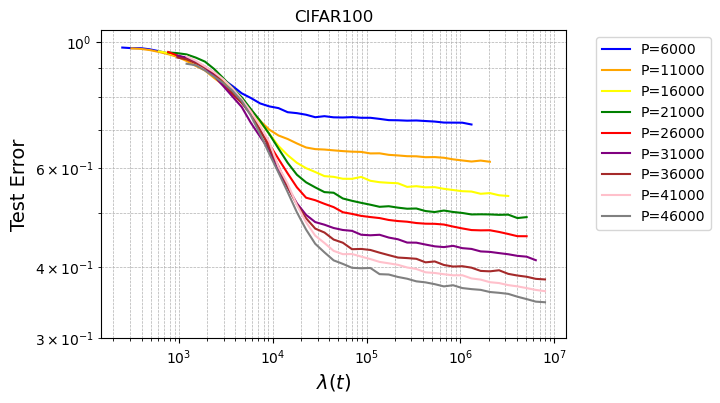

/tmp/ipykernel_19846/315783976.py:81: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
/tmp/ipykernel_19846/3312469580.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


<Figure size 600x400 with 0 Axes>

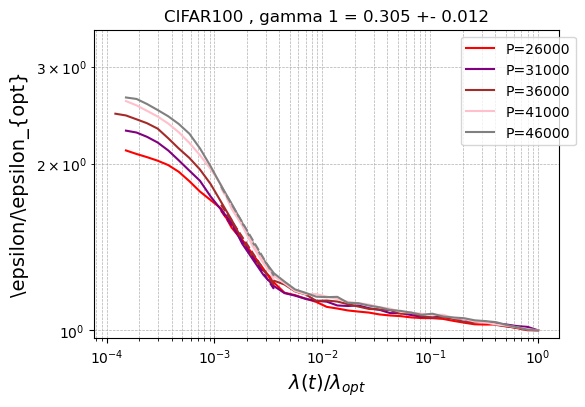

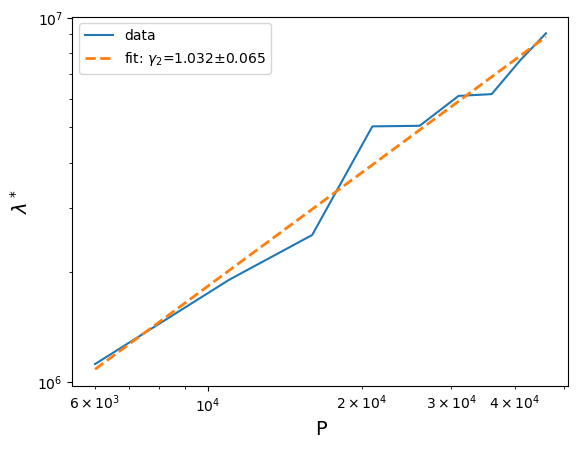

Fitted power law: k2 = 136.4, gamma2 = 1.032
gamma_pred =  0.31494363315699897


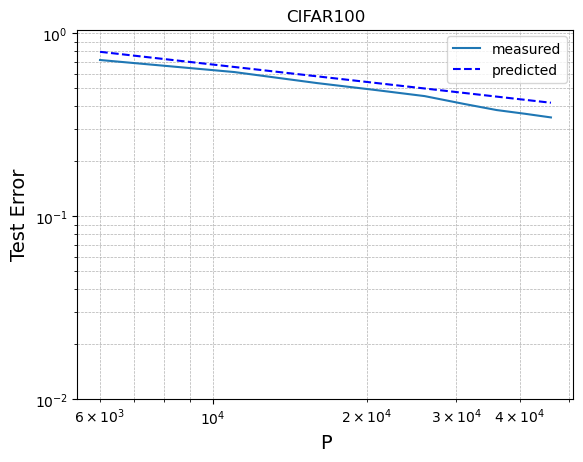

In [46]:
model = "ResNet"
dataset = "CIFAR100"
WD_name = "WD"
final = ""
WD = 0.0
P_arr = np.arange(6000, 46001, 5000)
seed_arr = np.arange(880,885) 
log_x_grid = np.logspace(2.2, 7, num=50)
mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))
    
l_0_arr, to_save = plot_results(dataset, P_arr, seed_arr, log_x_grid, exponential=False, ylimit=(0.3,1.05))

min_P = 4
x_left = 1e-3
x_right = 4e-3
exponential = False
to_save["min_P"] = min_P

P_arr_fit, gamma_1, k1, err_gamma_1 = fit_gamma_1(min_P, exponential, x_left, x_right, ylimits = (0.97,3.5))

l_power_law = l_0_arr[:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr, l_power_law)
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

constant = 250
final_plot(P_arr, gamma_1, gamma_2, constant, ylimits = (1e-2,1.05))

## ViT

### MNIST

/tmp/ipykernel_19846/315783976.py:31: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


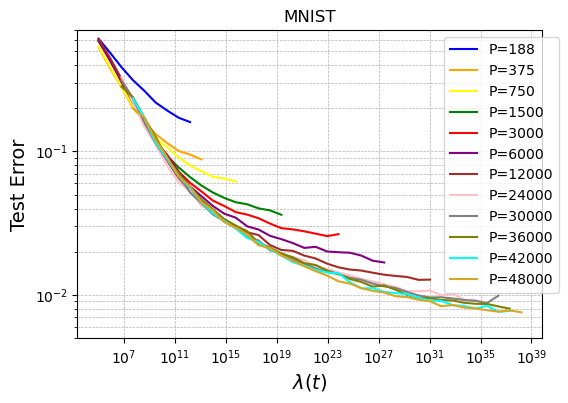

/tmp/ipykernel_19846/315783976.py:81: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
/tmp/ipykernel_19846/3312469580.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


<Figure size 600x400 with 0 Axes>

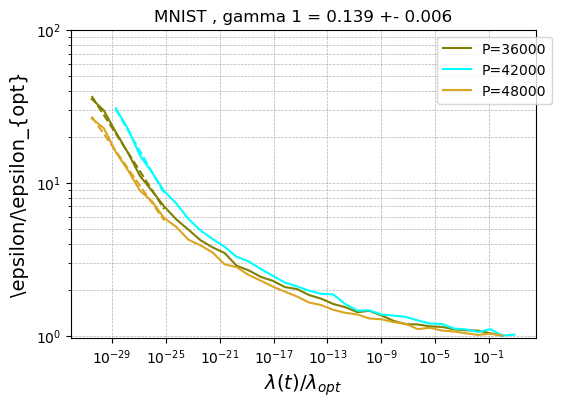

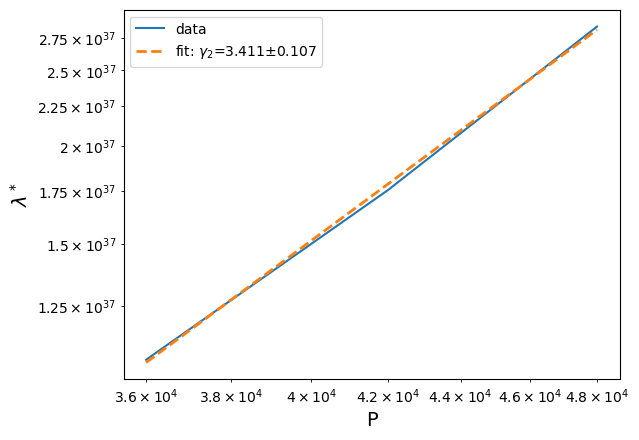

Fitted power law: k2 = 3.025e+21, gamma2 = 3.411
gamma_pred =  0.47309764396340076


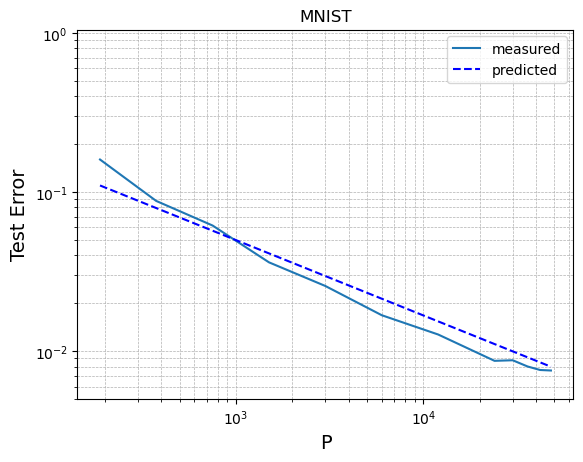

In [50]:
model = "ViT"
dataset = "MNIST"
WD_name = "WD"
final = ""
exponential = True
WD = 0.0
P_arr = np.array([188, 375, 750, 1500, 3000, 6000, 12000, 24000 ,30000 ,36000, 42000, 48000])
seed_arr = np.arange(11120,11130)
log_x_grid = np.logspace(5, 40, num=40)
mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))
    
l_0_arr, to_save = plot_results(dataset, P_arr, seed_arr, log_x_grid, exponential=exponential, ylimit=(0.005,0.7))

min_P = 9
x_left = None
x_right = 1e-25
to_save["min_P"] = min_P

P_arr_fit, gamma_1, k1, err_gamma_1 = fit_gamma_1(min_P, exponential, x_left, x_right, ylimits = (0.97,100.5))

l_power_law = l_0_arr[min_P:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr[min_P:], l_power_law)
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

constant = 500000
final_plot(P_arr, gamma_1, gamma_2, constant, ylimits = (5e-3,1.05))

### CIFAR10

/tmp/ipykernel_19846/315783976.py:31: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


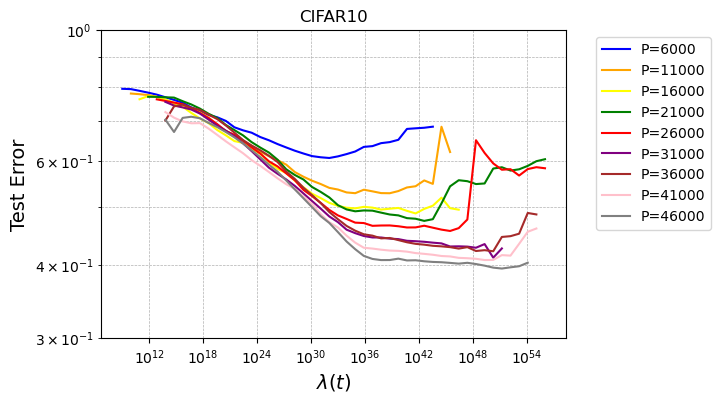

/tmp/ipykernel_19846/315783976.py:81: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
/tmp/ipykernel_19846/3312469580.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


<Figure size 600x400 with 0 Axes>

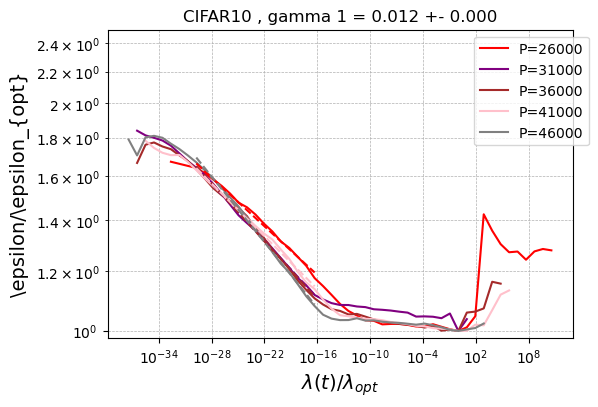

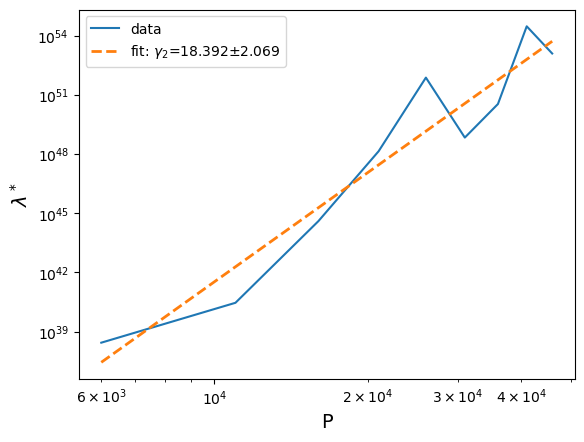

Fitted power law: k2 = 9.096e-33, gamma2 = 18.39
gamma_pred =  0.2288183247969192


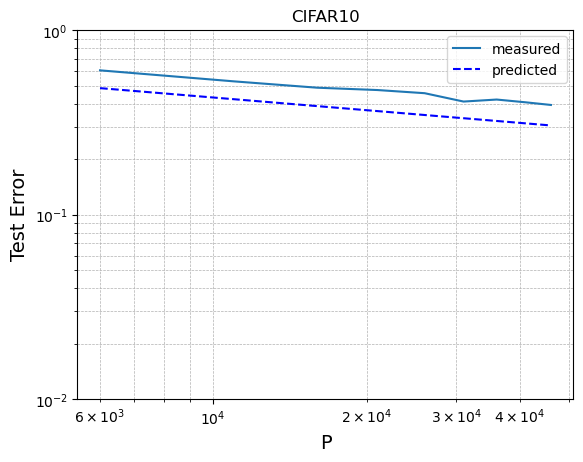

In [56]:
model = "ViT"
dataset = "CIFAR10"
WD_name = "WD"
final = "_INIT0.005"
exponential = True
WD = 0.0
P_arr = np.arange(6000, 46001, 5000)
seed_arr = np.arange(100,130)
log_x_grid = np.logspace(9, 56, num=50) 
mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))
    
l_0_arr, to_save = plot_results(dataset, P_arr, seed_arr, log_x_grid, exponential=exponential, ylimit=(0.3,1.))

min_P = 4
x_left = 1e-30
x_right = 1e-16
to_save["min_P"] = min_P

P_arr_fit, gamma_1, k1, err_gamma_1 = fit_gamma_1(min_P, exponential, x_left, x_right, ylimits = (0.98,2.5))

l_power_law = l_0_arr[:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr[:], l_power_law)
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

constant = 2
final_plot(P_arr, gamma_1, gamma_2, constant, ylimits = (1e-2,1.01))

### CIFAR100

/tmp/ipykernel_19846/315783976.py:31: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


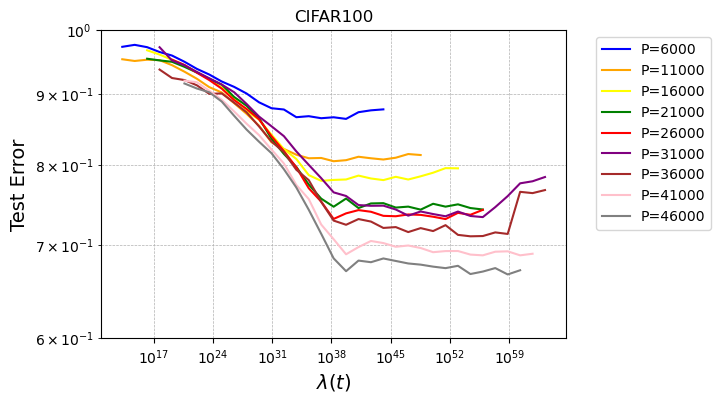

/tmp/ipykernel_19846/315783976.py:81: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
/tmp/ipykernel_19846/3312469580.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


<Figure size 600x400 with 0 Axes>

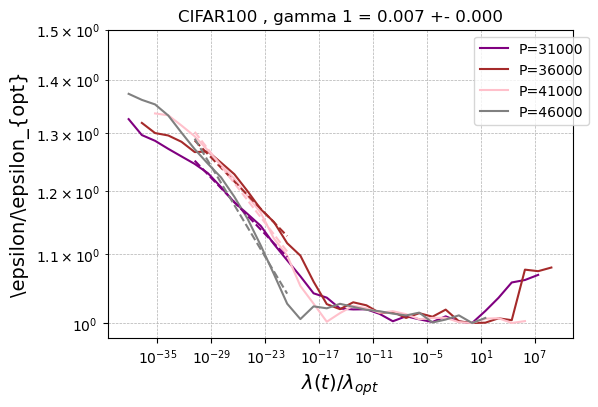

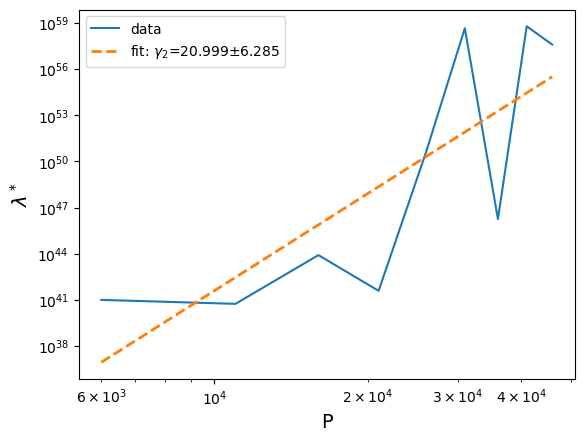

Fitted power law: k2 = 3.967e-43, gamma2 = 21
gamma_pred =  0.1429559624888969


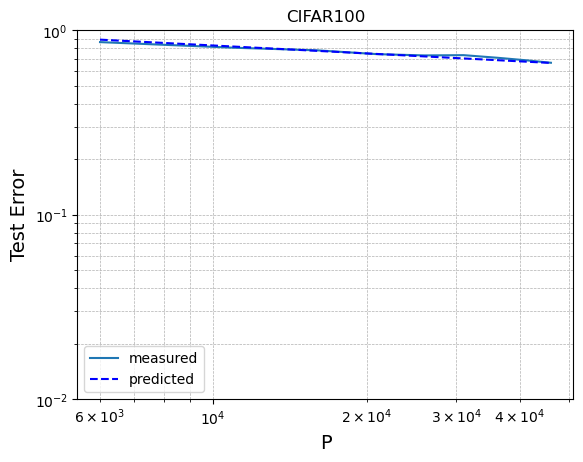

In [57]:
model = "ViT"
dataset = "CIFAR100"
WD_name = "WD"
final = "_INIT0.005"
exponential = True
WD = 0.0
P_arr = np.arange(6000, 46001, 5000)
seed_arr = np.arange(100,105)
log_x_grid = np.logspace(3, 75, num=50)
mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))
    
l_0_arr, to_save = plot_results(dataset, P_arr, seed_arr, log_x_grid, exponential=exponential, ylimit=(0.6,1.0))

min_P = 5
x_left = 1e-32
x_right = 1.5e-20
to_save["min_P"] = min_P

P_arr_fit, gamma_1, k1, err_gamma_1 = fit_gamma_1(min_P, exponential, x_left, x_right, ylimits = (0.98, 1.5))

l_power_law = l_0_arr[:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr[:], l_power_law)
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

constant = 2
final_plot(P_arr, gamma_1, gamma_2, constant, ylimits = (1e-2,1.01))